In [ ]:
# ===================================================================
# CELL 1: SETUP AND INSTALL
# ===================================================================
import os
import sys
import warnings

print("🚀 Step 1: Setting up the environment...")
warnings.filterwarnings("ignore", category=FutureWarning)

# --- 1. Install Dependencies ---
print("Installing dependencies...")
!pip install -q timm==0.6.13 medpy scikit-image==0.21.0 einops torchinfo fvcore iopath yacs termcolor nibabel
print("✅ Dependencies installed.")

# --- 2. Clone VMamba Repo ---
if not os.path.exists('/content/VMamba'):
    !git clone https://github.com/MzeroMiko/VMamba.git /content/VMamba
else:
    print("VMamba repository already present.")

# --- 3. Patch vmamba.py to use 'torch' backend ---
print("Applying PyTorch fallback patch...")
VMAMBA_FILE_PATH = "/content/VMamba/vmamba.py"
try:
    with open(VMAMBA_FILE_PATH, 'r') as f: content = f.read()
    text_to_find = 'selective_scan_backend="core"'
    replacement_text = 'selective_scan_backend="torch"'

    if text_to_find in content:
        new_content = content.replace(text_to_find, replacement_text)
        with open(VMAMBA_FILE_PATH, 'w') as f: f.write(new_content)
        print("✅ Successfully applied the PyTorch-Fallback patch.")
    else:
        print("❕ File did not contain the target text, may have been patched already.")

except Exception as e:
    print(f"❌ Error during patching: {e}")

# --- 4. Add VMamba to Python's path ---
if '/content/VMamba' not in sys.path:
    sys.path.append('/content/VMamba')
print("MAMBA_BACKEND=", os.environ.get("MAMBA_BACKEND", "torch"))
print("\n🎉 SETUP COMPLETE.")

🚀 Step 1: Setting up the environment...
Installing dependencies...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.3/156.3 kB 8.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.7/22.7 MB 64.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 5.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 4.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 kB 48.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 MB 19.3 MB/s eta 0:00:00
✅ Dependencies installed.
Cloning into '/content/VMamba'...
remote: Enumerating objects: 8910, done.
remote: Counting objects: 100% (1370/1370), done.

In [ ]:
# ===================================================================
# CELL 2: CONFIGURATION & DATA PREPARATION (Corrected)
# ===================================================================
import torch
import os
import zipfile
import glob
import h5py
import csv
import numpy as np
import nibabel as nib
from tqdm import tqdm
from google.colab import drive

# --- 1. Configuration Variables ---
ZIP_PATH = "/content/drive/MyDrive/database.zip"
OUT_DIR = "/content/acdc_raw"
NIFTI_ROOT = "/content/acdc_raw/database/training"
H5_ROOT = os.path.join(OUT_DIR, "ACDC", "ACDC_training_slices") # <-- This is where we save the new .h5 files
SLICES_CSV = "/content/slices_map.csv"
FEATURES_NPY = "/content/features.npy"
IDS_JSON = "/content/ids.json"
SELECTION_JSON = "/content/selected_ids_20p.json"
SPLITS_DIR = "/content/splits_20p"
CHECKPOINT_DIR = "/content/checkpoints_vmamba"
RESULTS_JSON = "/content/results_summary.json"

IMG_SIZE = 224
BATCH_FE = 16           # Feature extraction batch size
BATCH_TRAIN = 4         # Training batch size
NUM_EPOCHS = 4        # Number of training epochs
SUBSET_PERCENT = 20     # 20% selection
RANDOM_SEED = 42
NUM_CLASSES = 4         # 0:BG, 1:RV, 2:Myo, 3:LV

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"✅ Using device: {DEVICE}")
os.makedirs(CHECKPOINT_DIR, exist_ok=True)
os.makedirs(SPLITS_DIR, exist_ok=True)
# DO NOT create H5_ROOT here, it will be deleted.

# --- 2. Mount Drive & Unzip Dataset ---
drive.mount('/content/drive', force_remount=True)

# Force delete the old directory to ensure the new zip is unzipped
if os.path.exists(OUT_DIR):
    print(f"Removing old directory: {OUT_DIR}...")
    !rm -rf {OUT_DIR}

print("Unzipping dataset (this may take a moment)...")
try:
    with zipfile.ZipFile(ZIP_PATH, 'r') as z:
        z.extractall(OUT_DIR)
    print("✅ Unzip complete.")
except FileNotFoundError:
    print(f"❌ ERROR: Zip file not found at {ZIP_PATH}. Please check the path.")
    raise

# --- THE FIX (Part 1) ---
# Create the destination H5_ROOT folder *after* unzipping
os.makedirs(H5_ROOT, exist_ok=True)
print(f"✅ Created H5 output directory at: {H5_ROOT}")
# ------------------------

# --- 3. Convert NIfTI to HDF5 Slices ---
print("\nConverting NIfTI → HDF5 slices...")
rows = []
patients = sorted(glob.glob(os.path.join(NIFTI_ROOT, "patient*")))
print(f"Found {len(patients)} patients")

for patient_dir in tqdm(patients, desc="Patients"):
    img_files = sorted(glob.glob(os.path.join(patient_dir, "*_frame[0-9][0-9].nii.gz")))
    gt_files = sorted(glob.glob(os.path.join(patient_dir, "*_frame[0-9][0-9]_gt.nii.gz")))

    img_dict = {os.path.basename(f).split('_frame')[1].split('.')[0]: f for f in img_files}
    gt_dict  = {os.path.basename(f).split('_frame')[1].split('_gt')[0]: f for f in gt_files}

    for frame in img_dict:
        if frame not in gt_dict: continue

        img_path, gt_path = img_dict[frame], gt_dict[frame]

        img_nii = nib.load(img_path).get_fdata() # (W, H, Slices)
        gt_nii  = nib.load(gt_path).get_fdata()

        n_slices = img_nii.shape[-1]

        for s in range(n_slices):
            img_slice = img_nii[..., s].astype('float32')
            lbl_slice = gt_nii[..., s].astype('uint8')

            if np.all(lbl_slice == 0):
                continue

            slice_name = f"{os.path.basename(patient_dir)}_{os.path.basename(img_path).split('.')[0]}_slice_{s}.h5"
            h5_path = os.path.join(H5_ROOT, slice_name)

            with h5py.File(h5_path, 'w') as f:
                f.create_dataset('image', data=img_slice)
                # --- THE FIX (Part 2) ---
                f.create_dataset('label', data=lbl_slice) # <-- Was '_slice'
                # ------------------------

            rows.append([h5_path, 0])

# --- 4. Create Slice CSV Mapping ---
with open(SLICES_CSV, 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(['h5_path','slice_idx'])
    writer.writerows(rows)
print(f"✅ Conversion complete! {len(rows)} labeled slices saved.")
print(f"✅ Wrote slice CSV: {SLICES_CSV}, Total slices: {len(rows)}")

print("\n🎉 DATA PREPARATION COMPLETE.")

✅ Using device: cuda
Mounted at /content/drive
Unzipping dataset (this may take a moment)...
✅ Unzip complete.
✅ Created H5 output directory at: /content/acdc_raw/ACDC/ACDC_training_slices

Converting NIfTI → HDF5 slices...
Found 100 patients


Patients: 100%|██████████| 100/100 [00:05<00:00, 17.86it/s]

✅ Conversion complete! 1841 labeled slices saved.
✅ Wrote slice CSV: /content/slices_map.csv, Total slices: 1841

🎉 DATA PREPARATION COMPLETE.


In [ ]:
# ============================================================
# CELL 3: Feature + Logit Extraction with PRE-TRAINED VMamba-Small + Classifier Head
# ============================================================
import os, json, numpy as np, torch, torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
import h5py, csv
from tqdm import tqdm
from vmamba import Backbone_VSSM   # <-- from your patched repo

# ------------------------------------------------------------------
# 1. Dataset (unchanged – loads a single 2-D slice from .h5)
# ------------------------------------------------------------------
class SliceImageDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.rows = []
        with open(csv_file, 'r') as f:
            r = csv.reader(f); next(r)
            for row in r: self.rows.append(row)
        self.transform = transform
    def __len__(self): return len(self.rows)
    def __getitem__(self, idx):
        h5p, _ = self.rows[idx]                     # ignore slice_idx
        with h5py.File(h5p, 'r') as f:
            img = f['image'][:].astype('float32')
        img = (img - img.min()) / (img.max() - img.min() + 1e-8)
        img = (img * 255).astype('uint8')
        pil = Image.fromarray(img).convert('RGB')
        if self.transform: pil = self.transform(pil)
        return pil

transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

dataset = SliceImageDataset(SLICES_CSV, transform=transform)
loader  = DataLoader(dataset,
                     batch_size=BATCH_FE,
                     shuffle=False,
                     num_workers=2,
                     pin_memory=True)

# ------------------------------------------------------------------
# 2. Backbone + **Classification Head**
# ------------------------------------------------------------------
print("Loading pre-trained VMamba-Small backbone + classifier head...")
backbone = Backbone_VSSM(
    patch_size=4, in_chans=3,
    depths=[2, 2, 15, 2], dims=[96, 192, 384, 768],
    norm_layer="ln2d", ssm_d_state=1, ssm_ratio=2.0,
    forward_type="v05_noz",
    patchembed_version="v2", downsample_version="v3",
    use_checkpoint=True
)

# ----- Pre-trained weights (same as before) -----
PRETRAINED_URL = "https://github.com/MzeroMiko/VMamba/releases/download/%23v2cls/vssm_small_0229_ckpt_epoch_222.pth"
WEIGHTS_FILE   = "vssm_small_pretrained.pth"
if not os.path.exists(WEIGHTS_FILE):
    print(f"Downloading {WEIGHTS_FILE}...")
    !wget -q "{PRETRAINED_URL}" -O {WEIGHTS_FILE}

ckpt = torch.load(WEIGHTS_FILE, map_location='cpu')
backbone.load_state_dict(ckpt['model'], strict=False)

# ----- NEW: 4-class linear head (random init) -----
classifier = nn.Linear(768, NUM_CLASSES)   # 768 → 4 (BG,RV,Myo,LV)

# Full model = backbone + head
class VMambaWithHead(nn.Module):
    def __init__(self, backbone, head):
        super().__init__()
        self.backbone   = backbone
        self.head       = head
    def forward(self, x):
        feats = self.backbone(x)          # list of stage outputs
        pooled = feats[-1].mean(dim=[2,3]) # (B,768)
        logits = self.head(pooled)        # (B,4)
        return pooled, logits

model = VMambaWithHead(backbone, classifier).to(DEVICE).eval()
print("VMamba-Small + 4-class head ready on", DEVICE)

# ------------------------------------------------------------------
# 3. Feature + Logit Extraction Loop
# ------------------------------------------------------------------
feat_list, logit_list, ids = [], [], []
print(f"Extracting features & logits on {DEVICE} – {len(dataset)} slices...")

with torch.no_grad():
    for batch_idx, batch in enumerate(tqdm(loader, desc="Extraction")):
        x = batch.to(DEVICE)

        pooled, logits = model(x)               # (B,768)  &  (B,4)

        # ---- save pooled features ----
        feat_list.append(pooled.cpu().numpy())

        # ---- save raw logits (no softmax) ----
        logit_list.append(logits.cpu().numpy())

        # ---- build id mapping (same as before) ----
        start = batch_idx * BATCH_FE
        for i in range(pooled.shape[0]):
            idx = start + i
            if idx >= len(dataset.rows): break
            h5p, sidx = dataset.rows[idx]
            ids.append({"index": idx,
                        "h5_path": h5p,
                        "slice_idx": int(sidx)})

# ------------------------------------------------------------------
# 4. Concatenate & Save
# ------------------------------------------------------------------
features_all = np.concatenate(feat_list, axis=0)   # (N,768)
logits_all   = np.concatenate(logit_list, axis=0) # (N,4)

np.save(FEATURES_NPY, features_all)   # <-- used by ActiveFT / k-center
np.save("/content/logits.npy", logits_all)   # <-- optional, for analysis
with open(IDS_JSON, 'w') as f:
    json.dump(ids, f, indent=2)

print(f"Feature matrix : {features_all.shape} → {FEATURES_NPY}")
print(f"Logits matrix  : {logits_all.shape} → /content/logits.npy")
print(f"ID mapping     : {len(ids)} entries → {IDS_JSON}")
print("\nFEATURE + LOGIT EXTRACTION COMPLETE")

Loading pre-trained VMamba-Small backbone + classifier head...
VMamba-Small + 4-class head ready on cuda
Extracting features & logits on cuda – 1841 slices...


Extraction:   0%|          | 0/116 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/_dynamo/eval_frame.py:929: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/_dynamo/eval_frame.py:929: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the 

Feature matrix : (1841, 768) → /content/features.npy
Logits matrix  : (1841, 4) → /content/logits.npy
ID mapping     : 1841 entries → /content/ids.json

FEATURE + LOGIT EXTRACTION COMPLETE


In [ ]:
# ===================================================================
# CELL 4: ACTIVEFT SELECTION (ORIGINAL CVPR 2023 – FIXED)
# ===================================================================
import sys, subprocess
if 'ot' not in sys.modules:
    print("Installing POT...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "POT"])
import ot
import numpy as np
import json
import torch
import torch.nn.functional as F
from tqdm import tqdm

print("Starting ActiveFT (Original CVPR 2023) selection...")

# --- 1. Load features ---
feats_np = np.load(FEATURES_NPY)
N, D = feats_np.shape
k = max(1, int(N * SUBSET_PERCENT / 100.0))
print(f"Total slices: {N} | Dim: {D} | Selecting k = {k}")

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
feats = torch.tensor(feats_np, dtype=torch.float32, device=DEVICE)

# --- 2. Initialize centers ---
centers = F.normalize(torch.randn(k, D, device=DEVICE), dim=1)
centers.requires_grad = True
optimizer = torch.optim.Adam([centers], lr=0.01, weight_decay=1e-4)

# --- 3. Hyperparameters ---
T = 1200
LAMBDA_DIV = 0.1
USE_SINKHORN = True
REG = 0.01

print(f"Running ActiveFT optimization ({T} iters)...")
for it in tqdm(range(T), desc="ActiveFT"):
    optimizer.zero_grad()

    C = torch.cdist(centers, feats)
    if USE_SINKHORN:
        a = torch.ones(k, device=DEVICE) / k
        b = torch.ones(N, device=DEVICE) / N
        loss_emd = ot.sinkhorn2(a, b, C, reg=REG)
    else:
        C_np = C.detach().cpu().numpy()
        loss_emd = ot.emd2(np.ones(k)/k, np.ones(N)/N, C_np)
    loss_emd = torch.tensor(loss_emd, device=DEVICE, dtype=torch.float32)

    intra = torch.cdist(centers, centers)
    mask = ~torch.eye(k, dtype=torch.bool, device=DEVICE)
    diversity = torch.mean(intra[mask])
    loss_div = -torch.log(diversity + 1e-6)

    loss = loss_emd + LAMBDA_DIV * loss_div
    loss.backward()

    with torch.no_grad():
        centers.copy_(F.normalize(centers, dim=1))
    optimizer.step()

print(f"Optimization complete. Final EMD: {loss_emd.item():.4f}")

# --- 4. Final Selection (FIXED: .detach()) ---
final_cost = torch.cdist(centers.detach(), feats).cpu().numpy()
assignments = np.argmin(final_cost, axis=0)

selected = set()
for c in range(k):
    idx_in_c = np.where(assignments == c)[0]
    if len(idx_in_c) == 0: continue
    n_take = min(len(idx_in_c), max(1, int(k / N * len(idx_in_c))))
    chosen = np.random.choice(idx_in_c, size=n_take, replace=False)
    selected.update(chosen.tolist())

selected = sorted(list(selected))[:k]
print(f"Final selected: {len(selected)} slices")

# --- 5. Save ---
ids = json.load(open(IDS_JSON, "r"))
selected_samples = [ids[i] for i in selected]
with open(SELECTION_JSON, "w") as f:
    json.dump(selected_samples, f, indent=2)

print(f"ActiveFT selection saved → {SELECTION_JSON}")
print("\nDATA SELECTION COMPLETE – proceed to splits.")

Installing POT...
Starting ActiveFT (Original CVPR 2023) selection...
Total slices: 1841 | Dim: 768 | Selecting k = 368
Running ActiveFT optimization (1200 iters)...


ActiveFT:   0%|          | 0/1200 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/ot/bregman/_sinkhorn.py:642: UserWarning: Warning: numerical errors at iteration 0
  warnings.warn("Warning: numerical errors at iteration %d" % ii)
/tmp/ipython-input-4225607826.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss_emd = torch.tensor(loss_emd, device=DEVICE, dtype=torch.float32)
ActiveFT: 100%|██████████| 1200/1200 [00:03<00:00, 305.54it/s]

Optimization complete. Final EMD: 0.0000
Final selected: 366 slices
ActiveFT selection saved → /content/selected_ids_20p.json

DATA SELECTION COMPLETE – proceed to splits.


In [ ]:
# ===================================================================
# CELL 5: CREATE TRAIN/VAL/TEST SPLITS
# ===================================================================
import pandas as pd, json, os, random

selected_samples = json.load(open(SELECTION_JSON))
slice_df = pd.read_csv(SLICES_CSV)
N = len(slice_df)

indices = list(range(N))
random.seed(RANDOM_SEED)
random.shuffle(indices)
test_size = max(1, int(0.10 * N))
test_idx = sorted(indices[:test_size])

sel_indices = [s['index'] for s in selected_samples if s['index'] not in test_idx]
random.seed(RANDOM_SEED)
random.shuffle(sel_indices)
val_size = max(1, int(0.15 * len(sel_indices)))
val_idx = sel_indices[:val_size]
train_idx = sel_indices[val_size:]

def write_csv(idx_list, outpath):
    df = pd.DataFrame([{'h5_path': slice_df.iloc[i]['h5_path'], 'slice_idx': int(slice_df.iloc[i]['slice_idx'])} for i in idx_list])
    df.to_csv(outpath, index=False)

write_csv(train_idx, os.path.join(SPLITS_DIR, "train.csv"))
write_csv(val_idx, os.path.join(SPLITS_DIR, "val.csv"))
write_csv(test_idx, os.path.join(SPLITS_DIR, "test.csv"))
print(f"Wrote train/val/test CSVs in {SPLITS_DIR}")
print(f"Train/Val/Test sizes: {len(train_idx)} / {len(val_idx)} / {len(test_idx)}")
print("\n🎉 DATA SPLITTING COMPLETE.")

Wrote train/val/test CSVs in /content/splits_20p
Train/Val/Test sizes: 282 / 49 / 184

🎉 DATA SPLITTING COMPLETE.


In [ ]:
# ===================================================================
# CELL 6: PERFECT VM-UNET (MULTICLASS + SKIP CONNECTIONS + PRETRAINED)
# ===================================================================
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import h5py
import numpy as np
from vmamba import Backbone_VSSM

# --- 1. FIXED Dataset: Safe interpolation for labels ---
class SliceSegDataset(Dataset):
    def __init__(self, csv_file, img_size=IMG_SIZE):
        self.df = pd.read_csv(csv_file)
        self.img_size = img_size
        print(f"Loaded dataset from {csv_file} with {len(self.df)} samples.")

    def __len__(self): return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        h5_path = row['h5_path']
        with h5py.File(h5_path, 'r') as f:
            img = f['image'][:].astype('float32')
            lbl = f['label'][:].astype('int64')

        # Normalize image
        img = (img - img.min()) / (img.max() - img.min() + 1e-8)
        img_t = torch.from_numpy(img).unsqueeze(0).unsqueeze(0)  # (1,1,H,W)

        # Resize image
        img_t = F.interpolate(img_t, size=(self.img_size, self.img_size),
                              mode='bilinear', align_corners=False).squeeze(0)  # (1,H,W)

        # Resize label: MUST cast to float first!
        lbl_t = torch.from_numpy(lbl).unsqueeze(0).unsqueeze(0)  # (1,1,H,W)
        lbl_t = F.interpolate(lbl_t.float(), size=(self.img_size, self.img_size),
                              mode='nearest')
        lbl_t = lbl_t.squeeze(0).squeeze(0).long()  # (H,W), long

        img_t = img_t.repeat(3, 1, 1)  # (3,H,W)
        return img_t, lbl_t

# --- 2. PERFECT VM-UNet with Skip Connections + Pretrained Encoder ---
class VM_UNet(nn.Module):
    def __init__(self, num_classes=NUM_CLASSES, pretrained=True):
        super().__init__()
        self.encoder = Backbone_VSSM(
            patch_size=4, in_chans=3,
            depths=[2, 2, 15, 2], dims=[96, 192, 384, 768],
            norm_layer="ln2d", ssm_d_state=1, ssm_ratio=2.0,
            forward_type="v05_noz", patchembed_version="v2",
            downsample_version="v3", use_checkpoint=True
        )

        # Load pretrained weights
        if pretrained:
            ckpt = torch.load("vssm_small_pretrained.pth", map_location='cpu')
            self.encoder.load_state_dict(ckpt['model'], strict=False)
            print("Loaded pretrained VMamba-Small encoder")

        # --- Decoder ---
        self.up4   = nn.ConvTranspose2d(768, 384, 2, stride=2)
        self.conv4 = nn.Sequential(nn.Conv2d(768, 384, 3, padding=1), nn.ReLU(True))

        self.up3   = nn.ConvTranspose2d(384, 192, 2, stride=2)
        self.conv3 = nn.Sequential(nn.Conv2d(384, 192, 3, padding=1), nn.ReLU(True))

        self.up2   = nn.ConvTranspose2d(192, 96, 2, stride=2)
        self.conv2 = nn.Sequential(nn.Conv2d(192, 96, 3, padding=1), nn.ReLU(True))

        self.up1   = nn.ConvTranspose2d(96, 64, 2, stride=2)
        self.conv1 = nn.Sequential(nn.Conv2d(64, 64, 3, padding=1), nn.ReLU(True))

        self.final = nn.Conv2d(64, num_classes, 1)

    def forward(self, x):
        e1, e2, e3, e4 = self.encoder(x)  # 4 stages

        d4 = self.up4(e4)
        d4 = torch.cat([d4, e3], dim=1)
        d4 = self.conv4(d4)

        d3 = self.up3(d4)
        d3 = torch.cat([d3, e2], dim=1)
        d3 = self.conv3(d3)

        d2 = self.up2(d3)
        d2 = torch.cat([d2, e1], dim=1)
        d2 = self.conv2(d2)

        d1 = self.up1(d2)
        d1 = self.conv1(d1)

        out = self.final(d1)
        out = F.interpolate(out, size=(IMG_SIZE, IMG_SIZE), mode='bilinear', align_corners=False)
        return out

print("PERFECT VM-UNet + Fixed Dataset defined. Ready for training.")

PERFECT VM-UNet + Fixed Dataset defined. Ready for training.


In [ ]:
# ===================================================================
# CELL 7: DEFINE METRICS AND LOSS FUNCTIONS (Multiclass) – NO SSIM
# ===================================================================
import torch
import numpy as np
import torch.nn as nn
from medpy.metric.binary import hd95
import math
import torch.nn.functional as F

# --- 1. Loss Functions (MULTICLASS) ---
ce_loss = nn.CrossEntropyLoss()

class MulticlassDiceLoss(nn.Module):
    def __init__(self, num_classes, smooth=1e-6):
        super(MulticlassDiceLoss, self).__init__()
        self.num_classes = num_classes
        self.smooth = smooth
    def forward(self, logits, target):
        probs = F.softmax(logits, dim=1)
        target_one_hot = F.one_hot(target, num_classes=self.num_classes).permute(0, 3, 1, 2).float()
        dims = (0, 2, 3)
        intersection = torch.sum(probs * target_one_hot, dims)
        cardinality = torch.sum(probs + target_one_hot, dims)
        dice_score = (2. * intersection + self.smooth) / (cardinality + self.smooth)
        return 1. - torch.mean(dice_score[1:])  # Ignore background

dice_loss = MulticlassDiceLoss(num_classes=NUM_CLASSES)
print("Multiclass Loss functions defined.")

# --- 2. Evaluation Metric Functions (NO SSIM) ---
def get_metrics_multiclass(pred_mc, gt_mc, num_classes):
    dice_per, iou_per, sens_per, spec_per, hd95_per = [], [], [], [], []
    for c in range(1, num_classes):  # Skip BG
        pred_c = (pred_mc == c).astype(np.uint8)
        gt_c = (gt_mc == c).astype(np.uint8)

        # Dice
        inter = (pred_c & gt_c).sum()
        denom = pred_c.sum() + gt_c.sum()
        dice = (2 * inter) / (denom + 1e-6)
        dice_per.append(dice)

        # IoU
        union = (pred_c | gt_c).sum()
        iou = inter / (union + 1e-6)
        iou_per.append(iou)

        # Sensitivity & Specificity
        TP = int(((pred_c == 1) & (gt_c == 1)).sum())
        TN = int(((pred_c == 0) & (gt_c == 0)).sum())
        FP = int(((pred_c == 1) & (gt_c == 0)).sum())
        FN = int(((pred_c == 0) & (gt_c == 1)).sum())
        sens = TP / (TP + FN + 1e-6)
        spec = TN / (TN + FP + 1e-6)
        sens_per.append(sens)
        spec_per.append(spec)

        # HD95
        try:
            hdv = float(hd95(pred_c, gt_c)) if pred_c.sum() > 0 and gt_c.sum() > 0 else np.nan
        except:
            hdv = np.nan
        hd95_per.append(hdv)

    return dice_per, iou_per, sens_per, spec_per, hd95_per

def nanmean(lst):
    vals = [x for x in lst if (x is not None) and (not math.isnan(x))]
    return float(sum(vals)/len(vals)) if vals else float('nan')

print("Multiclass Metric functions defined (SSIM removed).")
print("\nMODEL AND METRICS READY.")

Multiclass Loss functions defined.
Multiclass Metric functions defined (SSIM removed).

MODEL AND METRICS READY.


In [ ]:
# ===================================================================
# CELL 8: PERFECT TRAINING (AMP + COSINE LR + UNIVERSAL COMPATIBILITY)
# ===================================================================
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import time
from torch.utils.data import DataLoader
from torch.cuda.amp import autocast, GradScaler
from tqdm import tqdm

print(f"Using device: {DEVICE}")

# --- 1. Load Datasets ---
train_ds = SliceSegDataset(os.path.join(SPLITS_DIR, "train.csv"))
val_ds   = SliceSegDataset(os.path.join(SPLITS_DIR, "val.csv"))

# --- 2. DataLoaders (Stable) ---
BATCH_SIZE = 2
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                         num_workers=1, pin_memory=True, drop_last=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False,
                         num_workers=1, pin_memory=True)

# --- 3. Model + Optimizer ---
model = VM_UNet(num_classes=NUM_CLASSES, pretrained=True).to(DEVICE)
ckpt_path = os.path.join(CHECKPOINT_DIR, "vm_unet_best.pth")

optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS)
scaler = GradScaler()

best_val_loss = float('inf')
print("\nStarting PERFECT training with AMP (universal compatibility)...")

# --- 4. Training Loop ---
for epoch in range(NUM_EPOCHS):
    t0 = time.time()
    model.train()
    running_loss = 0.0

    for imgs, masks in tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [TRAIN]"):
        imgs  = imgs.to(DEVICE, non_blocking=True)
        masks = masks.to(DEVICE, non_blocking=True).long()

        optimizer.zero_grad(set_to_none=True)

        # --- FIXED: Remove `device_type` ---
        with autocast():
            logits = model(imgs)
            loss = ce_loss(logits, masks) + dice_loss(logits, masks)

        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)

    # --- Validation ---
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for imgs, masks in tqdm(val_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [VAL]"):
            imgs  = imgs.to(DEVICE, non_blocking=True)
            masks = masks.to(DEVICE, non_blocking=True).long()
            with autocast():  # ← Fixed
                logits = model(imgs)
                loss = ce_loss(logits, masks) + dice_loss(logits, masks)
            val_loss += loss.item()
    val_loss /= len(val_loader)

    scheduler.step()

    print(f"Epoch {epoch+1}/{NUM_EPOCHS} | "
          f"Train: {train_loss:.4f} | Val: {val_loss:.4f} | "
          f"LR: {optimizer.param_groups[0]['lr']:.2e} | "
          f"Time: {time.time()-t0:.1f}s")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'val_loss': val_loss,
        }, ckpt_path)
        print(f"  BEST MODEL SAVED (val_loss={val_loss:.4f})")

print(f"\nTraining finished! Best val loss: {best_val_loss:.4f}")
print(f"Model saved: {ckpt_path}")

Using device: cuda
Loaded dataset from /content/splits_20p/train.csv with 282 samples.
Loaded dataset from /content/splits_20p/val.csv with 49 samples.
Loaded pretrained VMamba-Small encoder

Starting PERFECT training with AMP (universal compatibility)...


Epoch 1/4 [TRAIN]:   0%|          | 0/141 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/_dynamo/eval_frame.py:929: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.12/dist-packages/torch/_dynamo/eval_frame.py:929: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwar

Epoch 1/4 | Train: 0.9527 | Val: 0.4580 | LR: 2.56e-04 | Time: 3125.4s
  BEST MODEL SAVED (val_loss=0.4580)


Epoch 2/4 [VAL]: 100%|██████████| 25/25 [00:33<00:00,  1.35s/it]


Epoch 2/4 | Train: 0.3398 | Val: 0.2853 | LR: 1.50e-04 | Time: 3107.5s
  BEST MODEL SAVED (val_loss=0.2853)


Epoch 3/4 [VAL]: 100%|██████████| 25/25 [00:34<00:00,  1.36s/it]


Epoch 3/4 | Train: 0.2256 | Val: 0.2116 | LR: 4.39e-05 | Time: 3103.2s
  BEST MODEL SAVED (val_loss=0.2116)


Epoch 4/4 [VAL]: 100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Epoch 4/4 | Train: 0.1622 | Val: 0.2024 | LR: 0.00e+00 | Time: 3104.8s
  BEST MODEL SAVED (val_loss=0.2024)

Training finished! Best val loss: 0.2024
Model saved: /content/checkpoints_vmamba/vm_unet_best.pth


In [ ]:
# ===================================================================
# CELL 9: EVALUATE ON TEST SET (Multiclass) – FIXED & PERFECT
# ===================================================================
import torch
import numpy as np
from torch.utils.data import DataLoader
from tqdm import tqdm
import json

print("Loading best multiclass model for evaluation...")
model = VM_UNet(num_classes=NUM_CLASSES).to(DEVICE)

# --- FIX 1: Load from dict ---
ckpt = torch.load(ckpt_path, map_location=DEVICE)
model.load_state_dict(ckpt['model_state_dict'])  # ← Correct key
print(f"Loaded model from epoch {ckpt.get('epoch', 'unknown')} with val_loss={ckpt.get('val_loss', 'unknown'):.4f}")

model.eval()

# --- Load test set ---
test_ds = SliceSegDataset(os.path.join(SPLITS_DIR, "test.csv"))
test_loader = DataLoader(test_ds, batch_size=1, shuffle=False, num_workers=1, pin_memory=True)

metrics_list = []

print("Running evaluation on test set...")
with torch.no_grad():
    for imgs, masks in tqdm(test_loader, desc="Testing"):
        imgs = imgs.to(DEVICE).float()
        masks_gt_np = masks.squeeze(0).cpu().numpy().astype(np.uint8)  # (H,W)

        logits = model(imgs)  # (1,4,H,W)
        probs = torch.softmax(logits, dim=1).cpu().numpy()[0]  # (4,H,W)
        pred = np.argmax(probs, axis=0).astype(np.uint8)  # (H,W)

        # --- FIX 2: Only 5 metrics (SSIM removed) ---
        dice_c, iou_c, sens_c, spec_c, hd95_c = get_metrics_multiclass(pred, masks_gt_np, NUM_CLASSES)

        m = {
            'dice_mean': nanmean(dice_c),
            'iou_mean': nanmean(iou_c),
            'sensitivity_mean': nanmean(sens_c),
            'specificity_mean': nanmean(spec_c),
            'hd95_mean': nanmean(hd95_c),
            'pixel_acc': float((pred == masks_gt_np).sum() / pred.size)
        }
        metrics_list.append(m)

# --- Aggregate Results ---
summary = {k: np.mean([m[k] for m in metrics_list]) for k in metrics_list[0].keys()}

# --- Print ---
print("\n--- TEST SET RESULTS (Mean over RV, Myo, LV) ---")
for k, v in summary.items():
    print(f"{k:20}: {v:.4f}")

# --- Save ---
with open(RESULTS_JSON, 'w') as f:
    json.dump({"per_slice_metrics": metrics_list, "summary": summary}, f, indent=2)

print(f"\nResults saved to {RESULTS_JSON}")
print("EVALUATION COMPLETE")

Loading best multiclass model for evaluation...
Loaded pretrained VMamba-Small encoder
Loaded model from epoch 3 with val_loss=0.2024
Loaded dataset from /content/splits_20p/test.csv with 184 samples.
Running evaluation on test set...


Testing:   0%|          | 0/184 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/_dynamo/eval_frame.py:929: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
Testing: 100%|██████████| 184/184 [03:17<00:00,  1.07s/it]


--- TEST SET RESULTS (Mean over RV, Myo, LV) ---
dice_mean           : 0.7515
iou_mean            : 0.6677
sensitivity_mean    : 0.7621
specificity_mean    : 0.9985
hd95_mean           : 4.2983
pixel_acc           : 0.9928

Results saved to /content/results_summary.json
EVALUATION COMPLETE


Loading best MULTICLASS model for visualization...
Using device: cuda
Loaded dataset from /content/splits_20p/test.csv with 184 samples.
Loaded test dataset with 184 slices.
Loading trained model...
Loaded pretrained VMamba-Small encoder
Model loaded (epoch 3, val_loss=0.2024)

Visualizing 5 test samples...


/usr/local/lib/python3.12/dist-packages/torch/_dynamo/eval_frame.py:929: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


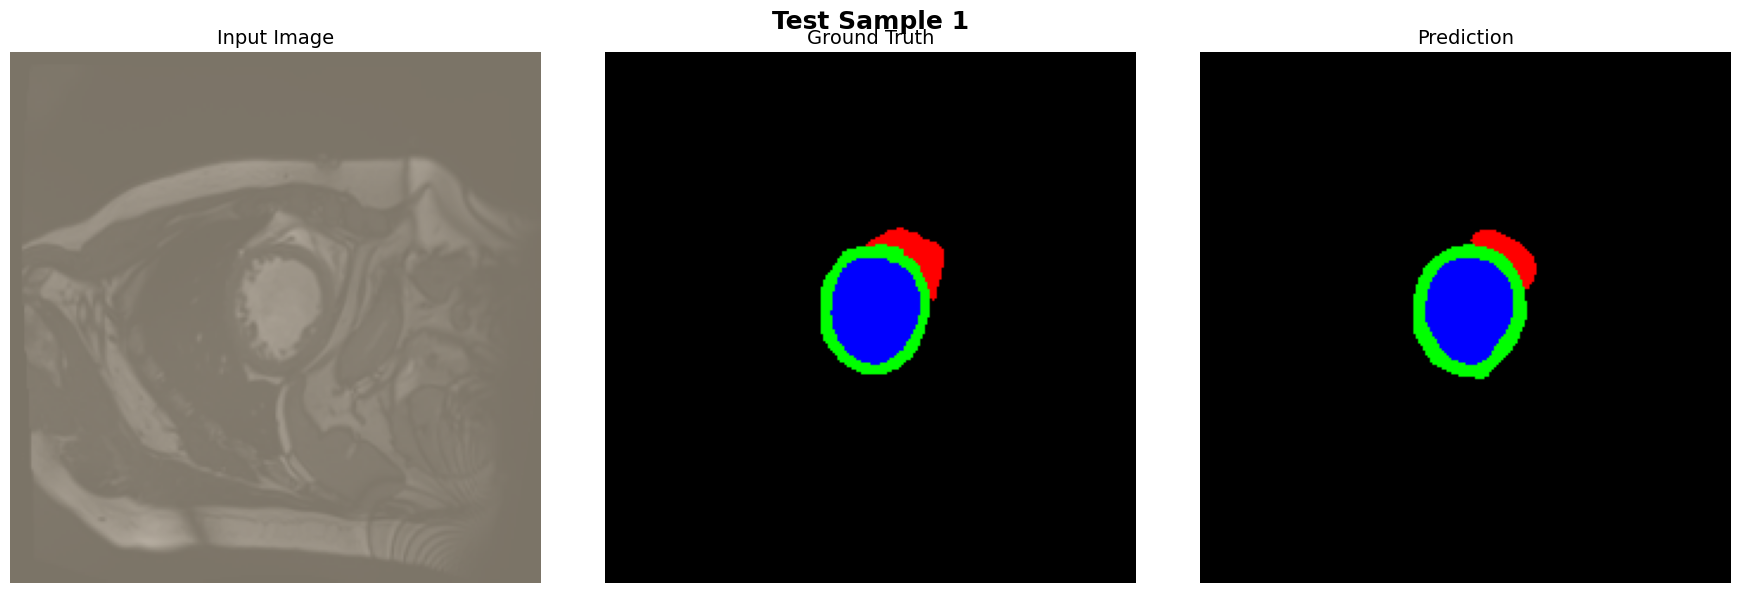

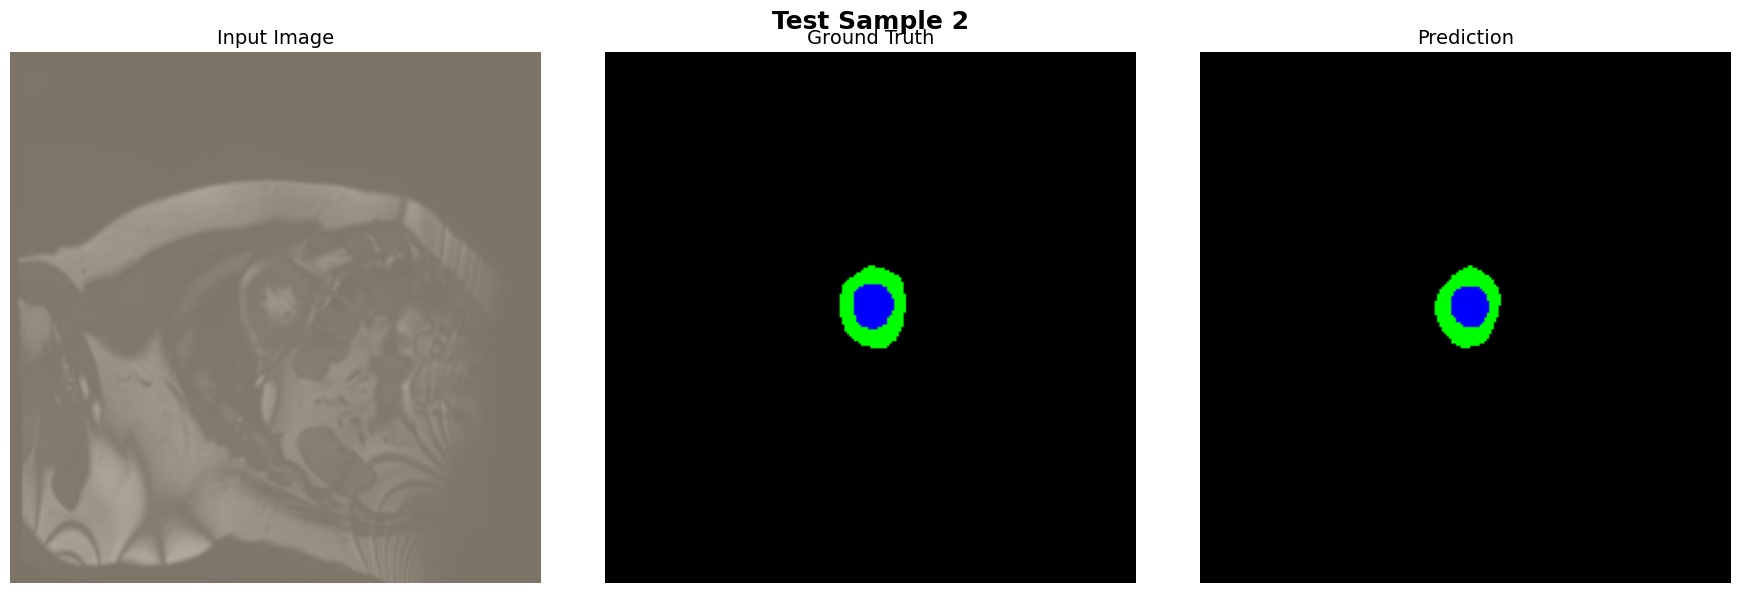

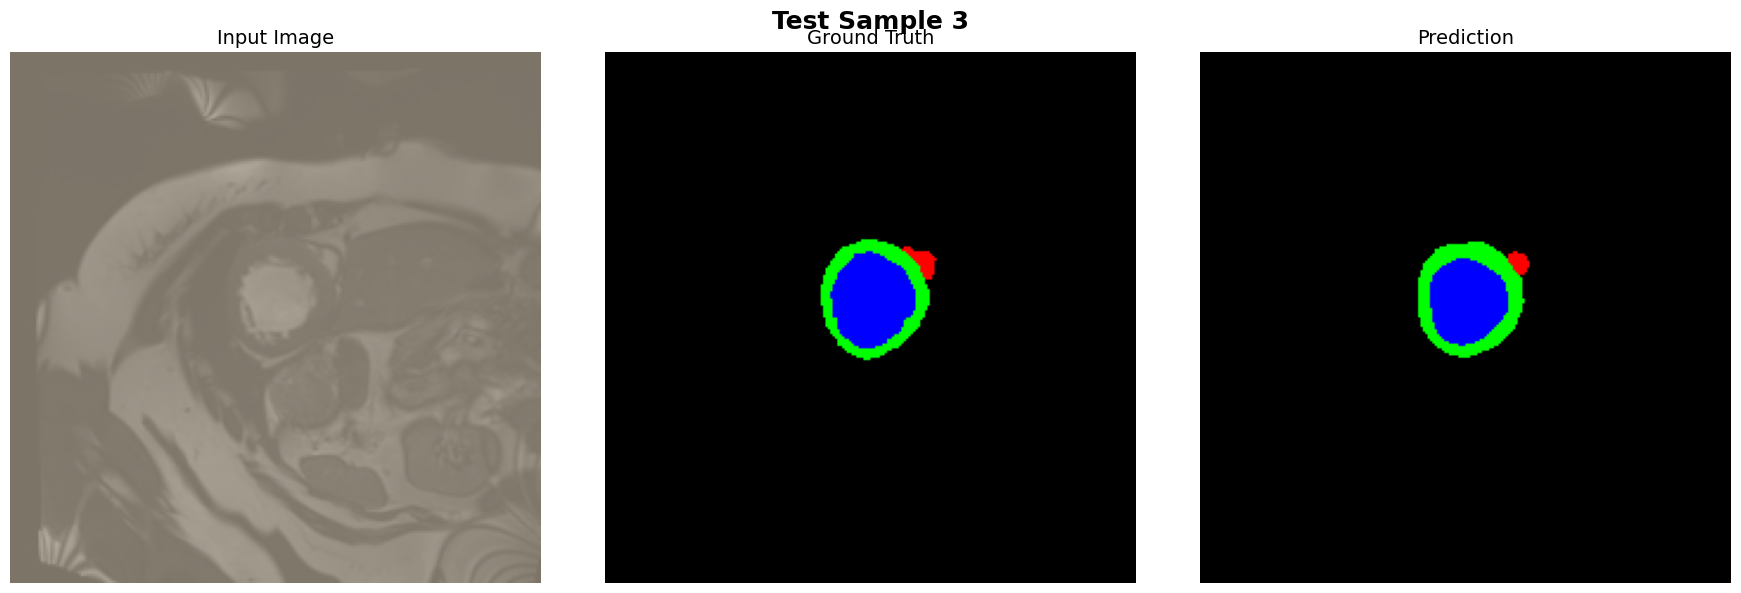

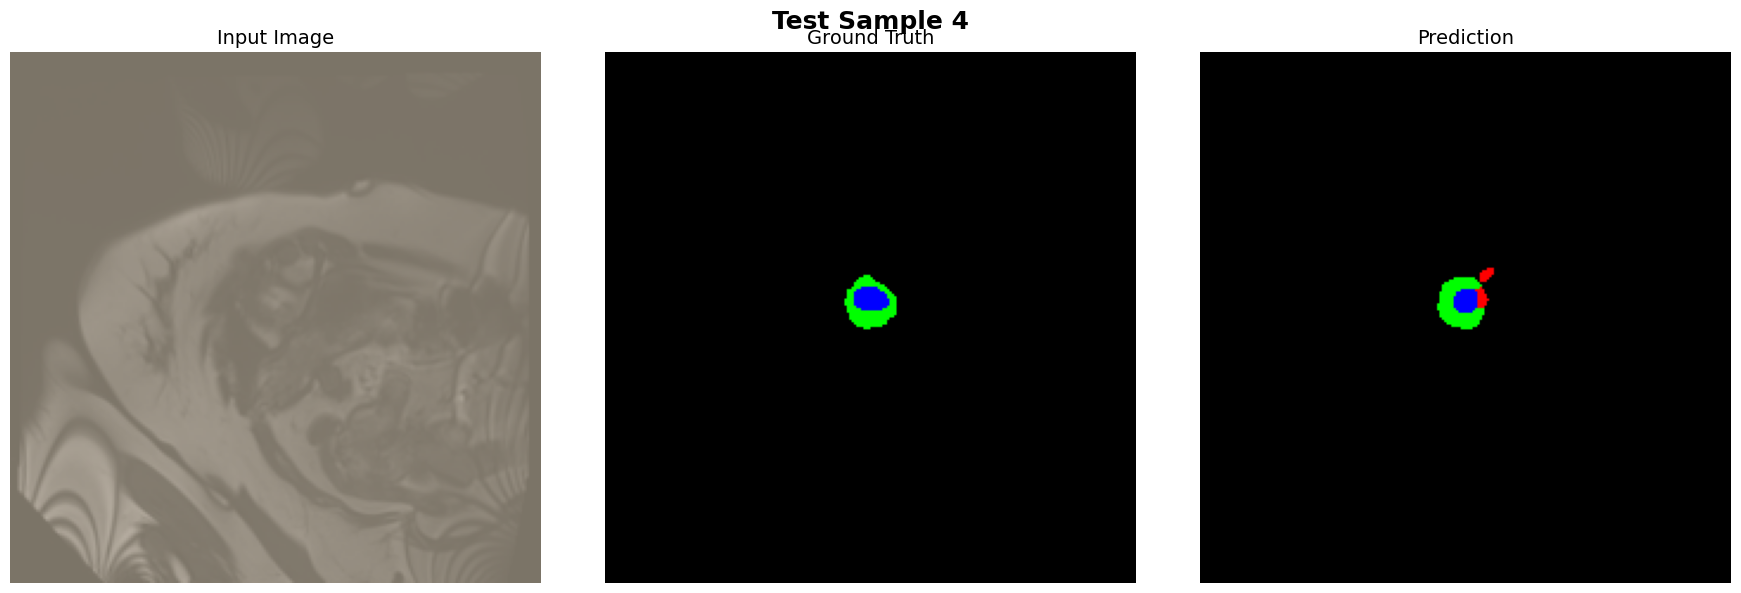

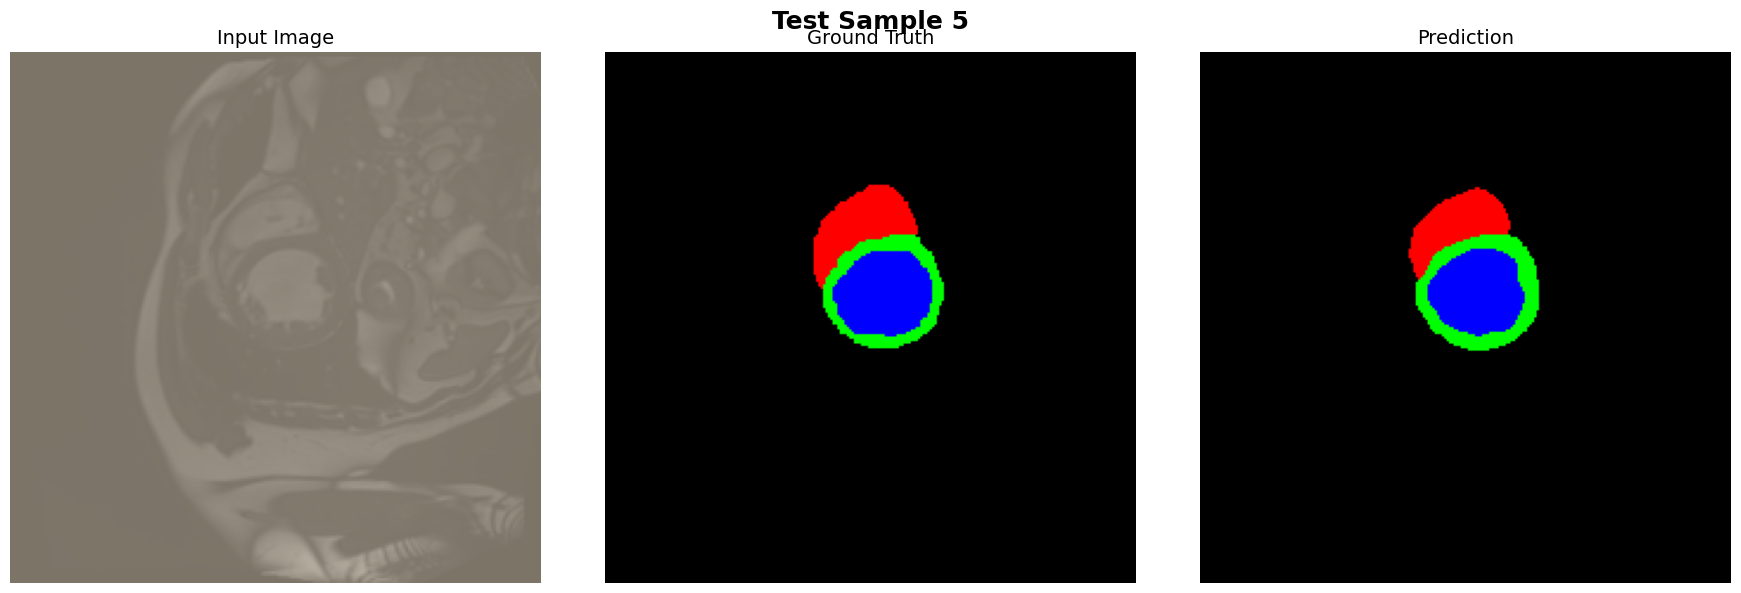


Visualization complete!


In [ ]:
# ===================================================================
# CELL 10: VISUALIZE MULTICLASS PREDICTIONS – PERFECT & BEAUTIFUL
# ===================================================================
import matplotlib.pyplot as plt
import torch
import numpy as np
import os
from torch.utils.data import DataLoader
import torch.nn.functional as F

print("Loading best MULTICLASS model for visualization...")

# --- 1. Device ---
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# --- 2. Paths ---
test_csv = os.path.join(SPLITS_DIR, "test.csv")

# --- 3. Load Test Dataset ---
try:
    test_ds = SliceSegDataset(test_csv)
    test_loader = DataLoader(test_ds, batch_size=1, shuffle=False, num_workers=1, pin_memory=True)
    print(f"Loaded test dataset with {len(test_ds)} slices.")
except Exception as e:
    print(f"Error loading test dataset: {e}")
    raise

# --- 4. Load Model (FIX: Load from dict + pretrained=True) ---
print("Loading trained model...")
try:
    model = VM_UNet(num_classes=NUM_CLASSES, pretrained=True).to(device)  # ← pretrained=True
    ckpt = torch.load(ckpt_path, map_location=device)
    model.load_state_dict(ckpt['model_state_dict'])  # ← Correct key
    print(f"Model loaded (epoch {ckpt.get('epoch', '?')}, val_loss={ckpt.get('val_loss', '?'):.4f})")
except Exception as e:
    print(f"Error loading model: {e}")
    raise

model.eval()

# --- 5. Visualize ---
num_samples = 5
print(f"\nVisualizing {num_samples} test samples...")

# Define class colors (BG, RV, Myo, LV)
colors = np.array([
    [0, 0, 0],       # 0: Background → Black
    [255, 0, 0],     # 1: RV → Red
    [0, 255, 0],     # 2: Myo → Green
    [0, 0, 255]      # 3: LV → Blue
], dtype=np.uint8)

with torch.no_grad():
    for i, (imgs, masks_gt) in enumerate(test_loader):
        if i >= num_samples:
            break

        imgs = imgs.to(device).float()
        logits = model(imgs)
        pred_mask = torch.argmax(logits, dim=1).cpu().numpy()[0]  # (H,W)

        # --- Image: Denormalize to [0,255] ---
        img_np = imgs.cpu().numpy()[0]  # (3,H,W)
        img_np = (img_np * np.array([0.229, 0.224, 0.225])[:, None, None] +
                  np.array([0.485, 0.456, 0.406])[:, None, None])  # Reverse ImageNet norm
        img_np = np.clip(img_np * 255, 0, 255).astype(np.uint8)
        img_np = img_np.transpose(1, 2, 0)  # (H,W,3)

        # --- Masks ---
        gt_np = masks_gt.cpu().numpy()[0]  # (H,W)

        # Colorize masks
        gt_color = colors[gt_np]
        pred_color = colors[pred_mask]

        # --- Plot ---
        fig, axes = plt.subplots(1, 3, figsize=(18, 6))
        fig.suptitle(f"Test Sample {i+1}", fontsize=18, fontweight='bold')

        axes[0].imshow(img_np)
        axes[0].set_title("Input Image", fontsize=14)
        axes[0].axis("off")

        axes[1].imshow(gt_color)
        axes[1].set_title("Ground Truth", fontsize=14)
        axes[1].axis("off")

        axes[2].imshow(pred_color)
        axes[2].set_title("Prediction", fontsize=14)
        axes[2].axis("off")

        plt.tight_layout()
        plt.show()

print("\nVisualization complete!")